# Embedding Model Selection

# Setup

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import sys
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
colours = sns.color_palette("Set2")
import warnings
warnings.filterwarnings("ignore")
from model_tester import test_embedding_models

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)
from utils import get_table_from_supabase

#get keys from env
load_dotenv()
url = os.getenv("SUPABASE_URL")
key = os.getenv("SUPABASE_KEY")

## Recipient Objectives

Until this point, the database was limited to recipient names and activities. I have chosen to extend this to include recipient objectives to hopefully enrich the data and provide another context to test for the embedding model selection. I have updated the database builders, so that objectives can be imported from the start in future iterations, and also created `2_recipients_table_builder/recipient_objectives_importer.py` so that I do not have to re-build the entire database at this point in the project.

----

# Retrieving Data from Supabase and Building Dataframes

I will connect to Supabase and retrieve the relevant records, in order to isolate the text data that I will use to embed and select the best model. For this purpose, I will use the 12 funder-recipient pairs that I have curated for my evaluation app.

In [ ]:
#get embedding pairs and extract ids
embedding_pairs = get_table_from_supabase(url, key, "embedding_pairs")
funder_ids = embedding_pairs["funder_registered_num"].unique()
eval_recip_ids = embedding_pairs["recipient_id"].unique()

#add my ratings to compare later
ratings = {
    1: 0.70,
    2: 0.10,
    3: 0.50,
    4: 0.15,
    5: 0.5,
    6: 0.75,
    7: 0.5,
    8: 0.85,
    9: 0.20,
    10: 0.5,
    11: 0.70,
    12: 0.5
}
embedding_pairs["my_rating"] = embedding_pairs["id"].map(ratings)

In [ ]:
#get the 12 funders and recipients
funders = get_table_from_supabase(url, key, "funders")
funders = funders[funders["registered_num"].isin(funder_ids)]

recipients = get_table_from_supabase(url, key, "recipients")
recipients = recipients[recipients["recipient_id"].isin(eval_recip_ids)]

#create dataframes
recipients_df = recipients.copy()
funders_df = funders.copy()

#add embedding columns to funder/recipient dfs
funders_df["embeddings"] = None
recipients_df["embeddings"] = None

#add funder and recipient names to pairs df
embedding_pairs = embedding_pairs.merge(
    funders_df[["registered_num", "name"]],
    left_on="funder_registered_num",
    right_on="registered_num",
    how="left"
)
embedding_pairs = embedding_pairs.rename(columns={"name": "funder_name"})
embedding_pairs = embedding_pairs.drop(columns=["registered_num"])
embedding_pairs = embedding_pairs.merge(
    recipients_df[["recipient_id", "recipient_name"]],
    on="recipient_id",
    how="left"
)

In [ ]:
#check dfs
print(f"Recipients: {recipients_df.shape} | Funders: {funders_df.shape} | Evaluation Pairs: {embedding_pairs.shape}")

In [ ]:
#get checkpoint folder
checkpoint_folder = Path("./7.1_checkpoints/")

#create checkpoint - save dfs to pickle
# recipients_df.to_pickle("recipients_df.pkl")
# funders_df.to_pickle("funders_df.pkl")
# embedding_pairs.to_pickle("embedding_pairs.pkl")

----

# Retrieving Data from Checkpoints

In [6]:
recipients_df = pd.read_pickle(checkpoint_folder / "recipients_df.pkl")
funders_df = pd.read_pickle(checkpoint_folder / "funders_df.pkl")
embedding_pairs = pd.read_pickle(checkpoint_folder / "embedding_pairs.pkl")

----

# Embedding Model Evaluation by Sections

I have chosen to test four models on my small evaluation dataset: 
- `all-MiniLM-L6-v2`
- `snowflake-arctic-embed-s`
- `all-roberta-large-v1`
- `bge-large-en-v1.5` 

Snowflake's model is generally finetuned for retrieval but I have decided to include it as it has performed so highly against other benchmarks and compared to major competitors (Merrick et al, 2024). The other models are consistent with the analysis by Pavlyshenko and Stasiuk (2025), who found these architectures to be reliable on semantic similarity tasks.

I will test each model on different sections from the funders and recipients dataframes, to determine which model produces embeddings that correlate best with my ratings, weighing up accuracy vs speed, and evaluating which section (or combination of sections) produces the best results.

In [7]:
#add model names
models = ["all-MiniLM-L6-v2", "Snowflake/snowflake-arctic-embed-s", "all-roberta-large-v1", "BAAI/bge-large-en-v1.5"]

## Test 1 - Activities Only

In [8]:
#prepare text columns
recipients_df["recipients_text"] = recipients_df["recipient_activities"].fillna("").str.lower()
funders_df["funders_text"] = funders_df["activities"].fillna("").str.lower()

results_act = []

In [9]:
#test models
results_act_df, pairs_act = test_embedding_models(
    models_list=models,
    funders_df=funders_df,
    recipients_df=recipients_df,
    embedding_pairs=embedding_pairs
)

all-MiniLM-L6-v2: 2.8s
Snowflake/snowflake-arctic-embed-s: 2.2s
all-roberta-large-v1: 4.2s
BAAI/bge-large-en-v1.5: 3.9s

Total test time: 13.1s


In [10]:
results_act_df

,model,correlation
0,all-MiniLM-L6-v2,0.606252
1,Snowflake/snowflake-arctic-embed-s,0.532136
2,all-roberta-large-v1,0.723535
3,BAAI/bge-large-en-v1.5,0.739029


In [11]:
#view pairs with scores from each model
pairs_act

,id,funder_registered_num,recipient_id,my_rating,funder_name,recipient_name,all-MiniLM-L6-v2_sim,Snowflake/snowflake-arctic-embed-s_sim,all-roberta-large-v1_sim,BAAI/bge-large-en-v1.5_sim
0,1,283423,221219,0.70,GUR TRUST,CARDIFF JEWISH HELPLINE,0.557142,0.793291,0.602727,0.576528
1,2,313303,1154453,0.10,MARC FITCH FUND,FRIENDS OF ANIMALS IN NEED,0.197431,0.638527,0.220884,0.406419
2,3,1011451,290462,0.50,CHRISTIAN DEVELOPMENT UGANDA,IBM UNITED KINGDOM TRUST,0.365567,0.789738,0.518371,0.655457
3,4,1060133,267039,0.15,HAMPSHIRE HOSPITALS CHARITY,SOLENT RESCUE,0.317997,0.756214,0.331801,0.466332
4,5,1189138,1187880,0.50,AFGHAN SPORTS TRUST (AST),ARTS4KENT,0.275089,0.657083,0.371707,0.649507
5,6,1041449,1147420,0.75,MIRACLES,BEYOND CANCER,0.483440,0.754553,0.445960,0.637562
6,7,801518,238372,0.50,BARRY AND PEGGY HIGH FOUNDATION,SOMERSET WILDLIFE TRUST,0.134283,0.728055,0.282212,0.493692
7,8,1199978,511702,0.85,360 GRASS ROOTS FOUNDATION,HULL CHILDREN'S ADVENTURE SOCIETY,0.323242,0.748191,0.525078,0.609121
8,9,296284,1204700,0.20,INSPIRE FOUNDATION,ABERYSTWYTH TOWN FOOTBALL CLUB FOUNDATION,0.123979,0.572870,0.135521,0.426864
9,10,273422,1135842,0.50,BRITISH ASSOCIATION FOR CEMETERIES IN SOUTH ASIA,BRAIN TUMOUR BUDDIES,0.206509,0.707212,0.235069,0.509568


### Observations

Two of the models have demonstrated fairly strong correlations with my ratings when comparing `activities` text: `BAAI/bge-large-en-v1.5` (r=0.73) and `all-roberta-large-v1` (r=0.72). There is clearly a trade-off between speed and accuracy, although I am not sure at this stage whether it will be so stark that it would be worth dropping any of the models. I will try `objectives`, plus combinations of the text columns, before making a final decision. 

## Test 2 - Objectives Only

In [12]:
#prepare text columns
recipients_df["recipients_text"] = recipients_df["recipient_objectives"].fillna("").str.lower()
funders_df["funders_text"] = funders_df["objectives"].fillna("").str.lower()

results_obj = []

In [13]:
#test models
results_obj_df, pairs_obj = test_embedding_models(
    models_list=models,
    funders_df=funders_df,
    recipients_df=recipients_df,
    embedding_pairs=embedding_pairs
)

all-MiniLM-L6-v2: 2.1s
Snowflake/snowflake-arctic-embed-s: 2.5s
all-roberta-large-v1: 7.1s
BAAI/bge-large-en-v1.5: 5.5s

Total test time: 17.2s


In [14]:
results_obj_df

,model,correlation
0,all-MiniLM-L6-v2,0.327544
1,Snowflake/snowflake-arctic-embed-s,0.502695
2,all-roberta-large-v1,0.688371
3,BAAI/bge-large-en-v1.5,0.634833


In [15]:
pairs_obj

,id,funder_registered_num,recipient_id,my_rating,funder_name,recipient_name,all-MiniLM-L6-v2_sim,Snowflake/snowflake-arctic-embed-s_sim,all-roberta-large-v1_sim,BAAI/bge-large-en-v1.5_sim
0,1,283423,221219,0.70,GUR TRUST,CARDIFF JEWISH HELPLINE,0.437126,0.848325,0.580698,0.528188
1,2,313303,1154453,0.10,MARC FITCH FUND,FRIENDS OF ANIMALS IN NEED,0.432430,0.766709,0.415479,0.542128
2,3,1011451,290462,0.50,CHRISTIAN DEVELOPMENT UGANDA,IBM UNITED KINGDOM TRUST,0.403102,0.794509,0.437849,0.624729
3,4,1060133,267039,0.15,HAMPSHIRE HOSPITALS CHARITY,SOLENT RESCUE,0.440307,0.788002,0.346878,0.524049
4,5,1189138,1187880,0.50,AFGHAN SPORTS TRUST (AST),ARTS4KENT,0.409941,0.824745,0.591121,0.688336
5,6,1041449,1147420,0.75,MIRACLES,BEYOND CANCER,0.372780,0.744481,0.450273,0.617626
6,7,801518,238372,0.50,BARRY AND PEGGY HIGH FOUNDATION,SOMERSET WILDLIFE TRUST,0.107357,0.731397,0.340071,0.502861
7,8,1199978,511702,0.85,360 GRASS ROOTS FOUNDATION,HULL CHILDREN'S ADVENTURE SOCIETY,0.546164,0.833259,0.640340,0.730950
8,9,296284,1204700,0.20,INSPIRE FOUNDATION,ABERYSTWYTH TOWN FOOTBALL CLUB FOUNDATION,0.184553,0.675054,0.243412,0.507999
9,10,273422,1135842,0.50,BRITISH ASSOCIATION FOR CEMETERIES IN SOUTH ASIA,BRAIN TUMOUR BUDDIES,0.297635,0.753520,0.357773,0.576838


### Observations

All four models performed worse on `objectives` alone, which is to be expected given that funders often declare more information in `activities`. For recipients in particular, values for `objectives` tend to be longer, hence the increased time taken to embed. 

## Test 3 - Activities and Objectives (API Only)

In [16]:
#prepare text columns
recipients_df["recipients_text"] = recipients_df["recipient_activities"].fillna("") + "" + recipients_df["recipient_objectives"].fillna("").str.lower()
funders_df["funders_text"] = funders_df["activities"].fillna("") + "" + funders_df["objectives"].fillna("").str.lower()

results_ao_api = []

In [17]:
#test models
results_ao_api, pairs_ao_api = test_embedding_models(
    models_list=models,
    funders_df=funders_df,
    recipients_df=recipients_df,
    embedding_pairs=embedding_pairs
)

all-MiniLM-L6-v2: 2.0s
Snowflake/snowflake-arctic-embed-s: 2.3s
all-roberta-large-v1: 5.7s
BAAI/bge-large-en-v1.5: 8.1s

Total test time: 18.1s


In [18]:
results_ao_api

,model,correlation
0,all-MiniLM-L6-v2,0.746534
1,Snowflake/snowflake-arctic-embed-s,0.598159
2,all-roberta-large-v1,0.807066
3,BAAI/bge-large-en-v1.5,0.795902


In [19]:
pairs_ao_api

,id,funder_registered_num,recipient_id,my_rating,funder_name,recipient_name,all-MiniLM-L6-v2_sim,Snowflake/snowflake-arctic-embed-s_sim,all-roberta-large-v1_sim,BAAI/bge-large-en-v1.5_sim
0,1,283423,221219,0.70,GUR TRUST,CARDIFF JEWISH HELPLINE,0.516422,0.789165,0.579361,0.630517
1,2,313303,1154453,0.10,MARC FITCH FUND,FRIENDS OF ANIMALS IN NEED,0.210857,0.661811,0.142984,0.504471
2,3,1011451,290462,0.50,CHRISTIAN DEVELOPMENT UGANDA,IBM UNITED KINGDOM TRUST,0.420214,0.812708,0.453675,0.680943
3,4,1060133,267039,0.15,HAMPSHIRE HOSPITALS CHARITY,SOLENT RESCUE,0.353044,0.761814,0.320771,0.523628
4,5,1189138,1187880,0.50,AFGHAN SPORTS TRUST (AST),ARTS4KENT,0.301765,0.677543,0.413856,0.654139
5,6,1041449,1147420,0.75,MIRACLES,BEYOND CANCER,0.521312,0.742330,0.570350,0.666375
6,7,801518,238372,0.50,BARRY AND PEGGY HIGH FOUNDATION,SOMERSET WILDLIFE TRUST,0.169243,0.684901,0.200548,0.514936
7,8,1199978,511702,0.85,360 GRASS ROOTS FOUNDATION,HULL CHILDREN'S ADVENTURE SOCIETY,0.559026,0.838391,0.513512,0.734836
8,9,296284,1204700,0.20,INSPIRE FOUNDATION,ABERYSTWYTH TOWN FOOTBALL CLUB FOUNDATION,0.176115,0.583986,0.240978,0.520629
9,10,273422,1135842,0.50,BRITISH ASSOCIATION FOR CEMETERIES IN SOUTH ASIA,BRAIN TUMOUR BUDDIES,0.227425,0.734453,0.362744,0.562164


### Observations

Combining the `activities` and `objectives` text columns has produced the best results so far, with `all-roberta-large-v1` outperforming the other models (r=0.81). It has performed better in terms of speed for this test too, now taking less time to embed than `BAAI/bge-large-en-v1.5` (although still more than twice as slow as the other two models). I will now combine all three text columns for `activities` and `objectives` to test how well the models perform when given all the available information.

## Test 4 - Activities and Objectives (Extracted and API)

In [20]:
#prepare text columns
recipients_df["recipients_text"] = recipients_df["recipient_activities"].fillna("") + "" + recipients_df["recipient_objectives"].fillna("").str.lower()
funders_df["funders_text"] = funders_df["activities"].fillna("") + "" + funders_df["objectives"].fillna("") + "" + funders_df["objectives_activities"].fillna("").str.lower()

results_ao_ext = []

In [21]:
#test models
results_ao_ext, pairs_ao_ext = test_embedding_models(
    models_list=models,
    funders_df=funders_df,
    recipients_df=recipients_df,
    embedding_pairs=embedding_pairs
)

all-MiniLM-L6-v2: 2.6s
Snowflake/snowflake-arctic-embed-s: 3.1s
all-roberta-large-v1: 6.2s
BAAI/bge-large-en-v1.5: 8.5s

Total test time: 20.4s


In [22]:
results_ao_ext

,model,correlation
0,all-MiniLM-L6-v2,0.721848
1,Snowflake/snowflake-arctic-embed-s,0.769735
2,all-roberta-large-v1,0.891904
3,BAAI/bge-large-en-v1.5,0.825110


In [23]:
pairs_ao_ext

,id,funder_registered_num,recipient_id,my_rating,funder_name,recipient_name,all-MiniLM-L6-v2_sim,Snowflake/snowflake-arctic-embed-s_sim,all-roberta-large-v1_sim,BAAI/bge-large-en-v1.5_sim
0,1,283423,221219,0.70,GUR TRUST,CARDIFF JEWISH HELPLINE,0.499828,0.784770,0.565029,0.646452
1,2,313303,1154453,0.10,MARC FITCH FUND,FRIENDS OF ANIMALS IN NEED,0.170908,0.640039,0.155086,0.455534
2,3,1011451,290462,0.50,CHRISTIAN DEVELOPMENT UGANDA,IBM UNITED KINGDOM TRUST,0.366500,0.743815,0.374264,0.576565
3,4,1060133,267039,0.15,HAMPSHIRE HOSPITALS CHARITY,SOLENT RESCUE,0.353192,0.727818,0.287377,0.545204
4,5,1189138,1187880,0.50,AFGHAN SPORTS TRUST (AST),ARTS4KENT,0.301765,0.677543,0.410907,0.654139
5,6,1041449,1147420,0.75,MIRACLES,BEYOND CANCER,0.546377,0.752861,0.569332,0.660608
6,7,801518,238372,0.50,BARRY AND PEGGY HIGH FOUNDATION,SOMERSET WILDLIFE TRUST,0.165137,0.727363,0.248324,0.507670
7,8,1199978,511702,0.85,360 GRASS ROOTS FOUNDATION,HULL CHILDREN'S ADVENTURE SOCIETY,0.559026,0.838391,0.548415,0.734836
8,9,296284,1204700,0.20,INSPIRE FOUNDATION,ABERYSTWYTH TOWN FOOTBALL CLUB FOUNDATION,0.176115,0.583986,0.231459,0.520629
9,10,273422,1135842,0.50,BRITISH ASSOCIATION FOR CEMETERIES IN SOUTH ASIA,BRAIN TUMOUR BUDDIES,0.134327,0.666406,0.333996,0.515344


### Observations

The final test shows that the models have performed best when given the combination of `activities` and `objectives` from the API, plus `objectives_activities` (if it exists) as extracted from accounts. Achieving a correlation coefficient of 0.83, `all-roberta-large-v1` gave the best performance and was also slightly faster than `BAAI/bge-large-en-v1.5`. Although it does require approximately twice the embedding time as the lighter models, I will proceed with RoBERTa as has proven itself to perform well on my domain-specific data (r=0.89).

## Visualisation of Best Results

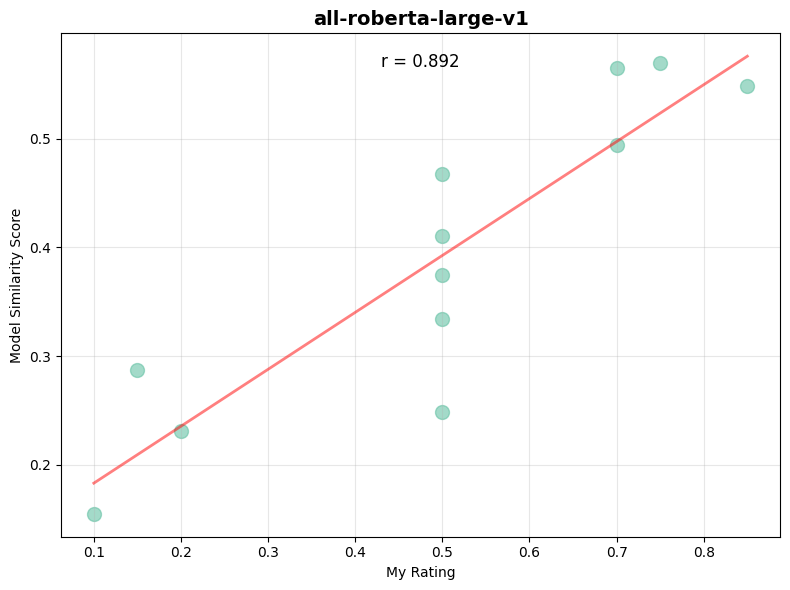

In [24]:
#make scatterplot for winner
fig, ax = plt.subplots(figsize=(8, 6))

model_col = "all-roberta-large-v1_sim"
correlation = results_ao_ext[results_ao_ext["model"] == "all-roberta-large-v1"]["correlation"].iloc[0]

ax.scatter(pairs_ao_ext["my_rating"], pairs_ao_ext[model_col],
           alpha=0.6, s=100, color=colours[0])

#show line of best fit
z = np.polyfit(pairs_ao_ext["my_rating"], pairs_ao_ext[model_col], 1)
p = np.poly1d(z)
ax.plot(pairs_ao_ext["my_rating"].sort_values(),
        p(pairs_ao_ext["my_rating"].sort_values()),
        "r-", alpha=0.5, linewidth=2)

ax.set_xlabel("My Rating")
ax.set_ylabel("Model Similarity Score")
ax.set_title("all-roberta-large-v1", fontsize=14, fontweight="bold")
ax.text(0.5, 0.96, f"r = {correlation:.3f}", 
        transform=ax.transAxes, ha="center", va="top", fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()